#### Imports

In [7]:
import PyPDF2
import csv
import re
import json
import os
import us
import numpy as np
import pandas as pd

In [8]:
YEAR = 1998

# OCR with Adobe Acrobat and extraction with fitz

In [2]:
from __future__ import print_function
from itertools import groupby
import fitz
import matplotlib.pyplot as plt

- Functions for reading text from PDF

In [964]:
def find_edges(x0s):
    '''
    Find the coordinates of boxes that seperates the columns in the PDF file.
    '''
    # only one row of data (p86, p143)
    if max(x0s) < 200: 
        return (None, None) 
    
    # 2 rows of data (p146, p218)
    # the one before zero and the one after zero has a difference greater than 20, 
    if max(x0s) < 400: 
        counts, xedges, _ = plt.hist(x0s, bins = 40)
        i = 8
        while i < 30:
            if (counts[i] == 0) and (max(counts[i + 1], counts[i + 2]) - counts[i - 1] > 20) and (xedges[i] > 160) and (xedges[i] < 220):
                return (xedges[i], None)
            i += 1
        if i == 30:
            i = 8
            while i < 30:
                if (max(counts[i], counts[i + 1]) - counts[i - 1] > 20) and (xedges[i] > 160) and (xedges[i] < 220):
                    return (xedges[i], None)
                i += 1
        if i == 30:
            i = 8
            while i < 30:
                if (counts[i] == 0) and (counts[i + 1] == 0) and (counts[i + 2] >= counts[i - 1]) and (xedges[i] > 160) and (xedges[i] < 220):
                    return (xedges[i], None)
                i += 1
        if i == 30:
            i = 8
            while i < 30:
                if (counts[i] == 0) and (counts[i + 1] == 0) and (xedges[i] > 160) and (xedges[i] < 220):
                    return (xedges[i], None)
                i += 1
    # 3 rows of data
    counts, xedges, _ = plt.hist(x0s, bins = 100)
    # line between col 1 & 2            
    i = 20
    while i < 45:
        if (counts[i] == 0) and (max(counts[i + 1], counts[i + 2]) - counts[i - 1] > 20) and (xedges[i] < 220):
            xcol1 = xedges[i]
            break
        i += 1
    if i == 45:
        i = 20
        while i < 45:
            if (max(counts[i], counts[i + 1]) - counts[i - 1] > 20) and (xedges[i] > 160) and (xedges[i] < 220):
                xcol1 = xedges[i]
                break
            i += 1
    if i == 45:
        i = 20
        while i < 45:
            if (counts[i] == 0) and (counts[i + 1] == 0) and (xedges[i] > 160) and (xedges[i] < 220):
                xcol1 = xedges[i + 1]
                break
            i += 1
            
    # line between col 2 & 3
    while i < 80:
        if (counts[i] == 0) and (max(counts[i + 1], counts[i + 2]) - counts[i - 1] > 20) and (xedges[i] > 330) and (xedges[i] < 390):
            xcol2 = xedges[i]
            break
        i += 1
    if i == 80:
        i = 50
        while i < 80:
            if (max(counts[i], counts[i + 1]) - counts[i - 1] > 20) and (xedges[i] > 330) and (xedges[i] < 390):
                xcol2 = xedges[i]
                break
            i += 1
    if i == 80:
        i = 50
        while i < 80:
            if (counts[i] == 0) and (counts[i + 1] == 0) and (xedges[i] > 330) and (xedges[i] < 390):
                xcol2 = xedges[i]
                break
            i += 1
    return (xcol1, xcol2)

In [965]:
def get_words_in_box(page):
    '''
    Extract words from each column of the PDF.
    '''
    x, y = page.MediaBox[2:] #size of page
    words = page.getText("words") #each word with extracted coordinate\
    #cut off top word if exist
    y0s = [word[1] for word in words]
    if sum(y0 < (min(y0s)+10) for y0 in y0s) < 3:
        words = [word for word in words if word[1] > (min(y0s)+10)]
    #cut off bottom
    words = [word for word in words if word[1] < (max(y0s)-10)]
    #find col 1 and 2
    x0s = [word[0] for word in words]
    xcol1, xcol2 = find_edges(x0s)
    page_txt = []
    if xcol1 == None:
        page_txt.append(words)
        return page_txt
    if xcol2 == None:
        page_txt.append([word for word in words if word[0] < xcol1])
        page_txt.append([word for word in words if word[0] > xcol1])
        return page_txt
    page_txt.append([word for word in words if word[0] < xcol1])
    page_txt.append([word for word in words if ((word[0] > xcol1) and (word[0] < xcol2))])
    page_txt.append([word for word in words if word[0] > xcol2])
    return page_txt

- Extract text

In [966]:
#open PDF which has gone through Adobe Acrobat OCR
doc = fitz.open("directory_1998_OCR.pdf")
len(doc)

568

In [967]:
#testing
# pagen = 218
# words = doc[pagen - 1].getText("words")
# y0s = [word[1] for word in words]
# if sum(y0 < (min(y0s)+10) for y0 in y0s) < 3:
#     words = [word for word in words if word[1] > (min(y0s)+10)]
# #cut off bottom
# words = [word for word in words if word[1] < (max(y0s)-10)]
# #find col 1 and 2
# x0s = [word[0] for word in words]
# find_edges(x0s)

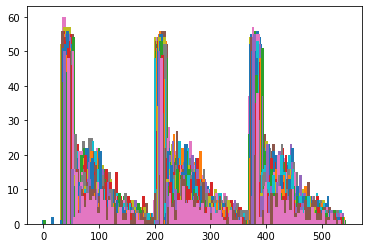

In [968]:
#get data
data = []
for pagen in range(12, 562):
    data.append(get_words_in_box(doc[pagen-1]))

# Write data into csv

- Split data into lines

In [969]:
abbr_keys = ["TX", "ML", "PV", "OS", "DT",\
             "OD", "OR", "IO", "ID", "IR", "RD", "RR",\
             "AD", "DD", "HV", "PW",\
             "SS", "GH", "PH", "OH", "TC", "HH", "CM", "CH", \
             "CO", "SG", "SC", "CJ",\
             "MC", "MD", "FG", "PI"]

In [970]:
def col_text_to_rows(col_text):
    '''
    Splits text into rows
    '''
    col_text_by_row = []
    temp = []
    init_y = col_text[0][1] #y0
    i = 0
    while i < len(col_text):
        if (col_text[i][1] < init_y + 5) and (col_text[i][1] > init_y - 5): #3
            temp.append(col_text[i][4])
        else:
            col_text_by_row.append(temp)
            temp = [col_text[i][4]]
            init_y = int(col_text[i][1])
        i += 1
    col_text_by_row.append(temp)
    return col_text_by_row

#runs the function on all data
def all_text_to_rows(data):
    all_text = []
    for page_text in data:
        page_text_by_row = []
        for col_text in page_text:
            page_text_by_row.append(col_text_to_rows(col_text))
        all_text.append(page_text_by_row)
    return all_text

In [971]:
#collect all text by page, column and line
all_text = all_text_to_rows(data)

- Writing text to .csv

In [1296]:
def clean_key(key):
    return key.replace('Y', 'V').replace('1', 'I').replace('l', 'I').replace('0', 'O').replace('OT', 'DT')\
.replace('OT', 'DT').replace('MU', 'ML')

def is_keys(line):
    '''
    Check if the line (list of list) is a list of keys
    exp. ['TX', 'OT/', 'RD', 'RR/', 'SS']
    '''
    if is_citystatezip(line):
        return False
    if any(x in line for x in address_indicators):
        return False
    if clean_key(line[0][:2]) in abbr_keys:
        if len(line) == 1:
            if len(line[0]) == 2 or len(line[0]) == 3:
                return True
            test = line[0].replace('/', '')
            if clean_key(test[2:4]) in abbr_keys:
                return True
            else:
                return False
        elif clean_key(line[1][:2]) in abbr_keys:
            return True
    return False

address_indicators = ['P.0.Box', 'Road', 'Highway', 'Route', 'Building', 'Street', 'Avenue', 'Suite', 'Drive', 'Boulevard', 'Level', 'Annex', \
                      'Streets', 'venue', 'Box'] #when Avenue is seperated...
name_indicators = ['Clinic', 'Center']

def is_address(line):
    if any(x in line for x in name_indicators):
        return False
    if line[0].replace('-', '').isnumeric() or any(x in line for x in address_indicators):
        return True
    return False

def is_contact(line):
    #['(650)368-6355']
    #['Hotlines:']
    line = ''.join(line)
    if line[:3] == 'Hot':
        return True
    if line[0] == '(' and line[1:4].replace('I', '1').replace('O', '0').replace('l', '1').replace('J', '1').isnumeric():
        return True
    return False

In [1297]:
#['Pasadena,', 'CA', '9', 'I', 'JO', '1-1804']
#['Prescott,', 'AZ', '8630', 'l']
#['Phoenix,', 'AZ', '850', 'I', '5']
#['Vandalia,', 'IL62471']
#['Macon.GA', '31201']
#['Cheboygan,MI49721']

def is_citystatezip(line):
    '''
    Check if the line contains city, state, zip info
    '''
    if any(x in line for x in address_indicators[:-1]): ##
        return False
    if len(line) == 1:
        if ('.' not in line[0]) and (',' not in line[0]):
            return False
        city, statezip = re.split(r'[,.]+', line[0])
        if statezip[:2].isupper() and statezip[2:]\
        .replace('I', '1').replace('l', '1').replace('J', '1').replace('!', '1').replace('O', '0').replace('-', '').isnumeric():
            return True
        return False
    if len(line) == 2:
        if line[-1][:2].isupper() and line[-1][2:]\
        .replace('I', '1').replace('l', '1').replace('J', '1').replace('!', '1').replace('O', '0').replace('-', '').isnumeric():
            return True
        if re.split(r'[,.]+', line[0])[-1].isupper() and line[1]\
        .replace('I', '1').replace('l', '1').replace('J', '1').replace('!', '1').replace('O', '0').replace('-', '').isnumeric():
            return True
        return False
    i = 0
    while i < len(line):
        if len(line[i]) == 2 and line[i].isupper():
            break
        i += 1
    if i == 0 or i == len(line):
        return False
    zipc = ''.join(line[i + 1:]).replace('I', '1').replace('l', '1').replace('J', '1').replace('!', '1').replace('O', '0').replace('-', '')
    if zipc.isnumeric() and (len(zipc) == 5 or len(zipc) == 9):
        return True
    return False

def clean_citystatezip(line):
    if len(line) == 1:
        city, statezip = re.split(r'[,.]+', line[0])
        return [city, statezip[:2], statezip[2:].replace('I', '1').replace('l', '1').replace('J', '1').replace('!', '1').replace('O', '0')]
    if len(line) == 2:
        if line[-1][:2].isupper() and line[-1][2:]\
        .replace('I', '1').replace('l', '1').replace('J', '1').replace('!', '1').replace('O', '0').replace('-', '').isnumeric():
            return [line[0][:-1], line[-1][:2], line[-1][2:]]
        else:
            city, state = re.split(r'[,.]+', line[0])
            state = state
            return [city, state, line[1]]
    i = 0
    while i < len(line):
        if len(line[i]) == 2 and line[i].isupper():
            break
        i += 1
    state = line[i]
    zipc = ''.join(line[i + 1:]).replace('I', '1').replace('l', '1').replace('l', '1').replace('J', '1').replace('!', '1').replace('O', '0')
    city = ' '.join(line[0:i])[:-1]
    return [city, state, zipc]

In [1298]:
def split_col_data(col_text):
    '''
    Split column data into list of MOUD facilities.
    '''
    col_text_splitted = []
    temp = []
    i = 0
    while i < len(col_text) - 1:
        
        if re.search('[a-zA-Z0-9]', ''.join(col_text[i])): ##
            
            if is_keys(col_text[i]) and (not is_keys(col_text[i+1])):
                temp.append(col_text[i])
                col_text_splitted.append(temp)
                temp = []
            elif is_keys(col_text[i]) and (is_keys(col_text[i+1])):
                temp.append(col_text[i])
            else:
                if not ''.join(col_text[i]).isupper(): #not the capitalized city name which should be ignored
                    temp.append(col_text[i])
                
        i += 1
    temp.append(col_text[-1])
    col_text_splitted.append(temp)
    return col_text_splitted

In [1299]:
def clean_col_data(col_text_splitted):
    '''
    Splits data into list of lists with
    name1, name2, address1, address2, city, state, zip, phone, keys
    '''
    data_holders = []
    for facil in col_text_splitted:
        if len(facil) > 2:
            data_holder = []
            i = 0 #indicator of next line
            #name1
            data_holder.append(' '.join(facil[0])) 
            i += 1
            #name2
            if not is_address(facil[i]) and not is_citystatezip(facil[i]) and not is_contact(facil[i]): 
                data_holder.append(' '.join(facil[i])) 
                i += 1
            else:
                data_holder.append('') 
            #name3
            if not is_address(facil[i]) and not is_citystatezip(facil[i]) and not is_contact(facil[i]): 
                data_holder.append(' '.join(facil[i])) 
                i += 1
            else:
                data_holder.append('')         
            #address1
            if is_address(facil[i]):
                data_holder.append(' '.join(facil[i])) 
                i += 1
            else:
                data_holder.append('')
            #address2
            if is_address(facil[i]) and not is_citystatezip(facil[i]) : ##
                data_holder.append(' '.join(facil[i])) 
                i += 1
            elif not is_citystatezip(facil[i]) and not is_contact(facil[i]) and not (is_keys(facil[i])): 
                data_holder.append(' '.join(facil[i])) 
                i += 1
            else:
                data_holder.append('')
            #address3
            if is_address(facil[i]) and not is_citystatezip(facil[i]):
                data_holder.append(' '.join(facil[i])) 
                i += 1
            else:
                data_holder.append('')
            #city, state, zip
            ## print(facil[i])
            ## print(data_holder)
            data_holder += clean_citystatezip(facil[i])
            i += 1
            #contact
            if is_contact(facil[i]):
                data_holder.append(''.join(facil[i]))
                i += 1
                while i < len(facil):
                    if is_contact(facil[i]):
                        data_holder[-1] += ' ' + ''.join(facil[i])
                        i += 1
                    else:
                        break
            else:
                data_holder.append('')
            #keys
            data_holder.append('')
            for keys in facil[i:]:
                for key in keys:
                    if len(key) == 1:
                        pass
                    elif len(key) == 2:
                        data_holder[-1] += clean_key(key) + '/'
                    elif len(key) == 3:
                        data_holder[-1] += clean_key(key[:2]) + '/'
                    else:
                        for key in key.split('/'):
                            if len(key) == 2:
                                data_holder[-1] += clean_key(key) + '/'
                            else:
                                data_holder[-1] += '/'.join([clean_key(key[i:i+2]) for i in range(0, len(key), 2)])
            data_holders.append(data_holder)
            print(".", end = '') #for each MOUD
    return data_holders

In [1300]:
with open(filename, 'w', newline = '') as file:
    writer = csv.writer(file)
    writer.writerow(["Name1", "Name2", 'Name3', "Address1", "Address2", "Address3", "City", "State", "ZIP_Code", "Contact", "Keys"])

In [1301]:
filename = "1998.csv"
pagen = 12

for page in all_text:
    print("Page:", pagen, end = '')
    page_data_holders = []
    for col in page:
        col_text_splitted = split_col_data(col)
        page_data_holders += clean_col_data(col_text_splitted)
        print(" Finished Col ", end = '')
    with open(filename, 'a', newline = '') as file:
        writer = csv.writer(file)
        writer.writerows(page_data_holders)
    pagen += 1
    print('')

Page: 12....... Finished Col ....... Finished Col ...... Finished Col 
Page: 13...... Finished Col ...... Finished Col ....... Finished Col 
Page: 14........ Finished Col ...... Finished Col ...... Finished Col 
Page: 15........ Finished Col ....... Finished Col ...... Finished Col 
Page: 16....... Finished Col ........ Finished Col ...... Finished Col 
Page: 17....... Finished Col ....... Finished Col .. Finished Col 
Page: 18...... Finished Col ....... Finished Col ....... Finished Col 
Page: 19....... Finished Col ........ Finished Col ....... Finished Col 
Page: 20....... Finished Col ......... Finished Col ........ Finished Col 
Page: 21........ Finished Col ....... Finished Col ....... Finished Col 
Page: 22....... Finished Col ...... Finished Col ....... Finished Col 
Page: 23........ Finished Col ........ Finished Col ........ Finished Col 
Page: 24...... Finished Col ...... Finished Col ....... Finished Col 
Page: 25....... Finished Col ........ Finished Col ........ Finished 

In [1295]:
#check error data
pagen = 304
col = 1
MOUD = 6
#all_text[pagen - 12][col - 1]
split_col_data(all_text[pagen - 12][col - 1])[MOUD-1]

[['Rocky', 'Boys', 'Chemical', 'Dependency', 'Center'],
 ['Rural', 'Route', 'I'],
 ['Box', 'Elder,', 'MT', '59521'],
 ['(406)395-4837'],
 ['TX', 'PY', 'OS/', 'OR/', 'AD', 'DD', 'PW/', 'SS/', 'FG']]

- Rewrite data in problem pages

In [976]:
# pagen = 23
# col = 2
# all_text[pagen - 12][col - 1][5] = ['TX', 'ML', 'PV', 'OS', 'DT/', 'OD', 'OR/', 'DD', 'HY', 'PW/']

# pagen = 38
# col = 1
# all_text[pagen - 12][col - 1][28] = ['Eureka,', 'CA', '95503']

# pagen = 43
# col = 2
# all_text[pagen - 12][col - 1][7] = ['83844', 'Hopi', 'A', 'venue']
# all_text[pagen - 12][col - 1][7] = ['Indio,', 'CA', '92201']
# all_text[pagen - 12][col - 1][9] = ['(760)347-9442']

# pagen = 45
# col = 3
# all_text[pagen - 12][col - 1][4] = ['Long', 'Beach,', 'CA', '90813']

# pagen = 75
# col = 3
# all_text[pagen - 12][col - 1][3] = ['Santa', 'Cruz,', 'CA', '95060']

# pagen = 80
# col = 2
# all_text[pagen - 12][col - 1][18] = ['Thousand', 'Oaks,', 'CA', '9', 'I', '360']

# pagen = 85
# col = 3
# all_text[pagen - 12][col - 1][4] = ['Winterhaven,', 'CA', '92283']

# pagen = 89
# col = 1
# all_text[pagen - 12][col - 1][12] = ['TX', 'OSI', 'OR/', 'SS', 'SG']

# pagen = 95
# col = 3
# all_text[pagen - 12][col - 1].insert(5, ['(303)238-1231'])

# pagen = 106
# col = 1
# all_text[pagen - 12][col - 1][3] = ['Claymont,', 'DE', '19703']

# pagen = 146
# col = 1
# del all_text[pagen - 12][col - 1][28]
# all_text[pagen - 12][col - 1][27] = ['Schofield', 'Barracks,', 'HI', '96857-5000']

# pagen = 146
# col = 2
# MOUD = 3
# del all_text[pagen - 12][col - 1][17]
# all_text[pagen - 12][col - 1][16] = ['Waianae,', 'HI', '96792']

In [977]:
# pagen = 196
# col = 3
# all_text[pagen - 12][col - 1][4] = ['TX', "PV", 'OS/', 'OR', 'IO', 'IR', 'RR/', 'AD', 'DD/', 'SS', 'PH']
# all_text[pagen - 12][col - 1][8] = ['6301', 'Pflumm', 'Street']
# all_text[pagen - 12][col - 1][9] = ['Suite', '140']
# all_text[pagen - 12][col - 1][10] = ['Shawnee,', 'KS', '66216']
# all_text[pagen - 12][col - 1][14] = ['TX', 'PV', 'OS', 'DT/', 'OD', 'OR', 'IO/', 'AD', 'DD/', 'SS/', 'PI']
# i = 0
# while i < len(all_text[pagen - 12][col - 1]):
#     j = 0
#     while j < len(all_text[pagen - 12][col - 1][i]):
#         all_text[pagen - 12][col - 1][i][j] = all_text[pagen - 12][col - 1][i][j].replace('\\', '')
#         j += 1
#     i += 1
# all_text[pagen - 12][col - 1][18] = ['Shawnee,', 'KS', '66216']
# all_text[pagen - 12][col - 1][29] = ['Shawnee,', 'KS', '66216']
# all_text[pagen - 12][col - 1][34] = ['TX', 'PY', 'OS', 'OR/', 'AD/', 'SG']

In [1248]:
# pagen = 253
# while pagen < 279:
#     k = 0
#     while k < 3:
#         i = 0
#         while i < len(all_text[pagen - 12][k]):
#             j = 0
#             while j < len(all_text[pagen - 12][k][i]):
#                 all_text[pagen - 12][k][i][j] = all_text[pagen - 12][k][i][j].replace('Ml', 'MI').replace('Mf', 'MI')
#                 j += 1
#             i += 1
#         k += 1
#     pagen += 1

# pagen = 418
# col = 3
# all_text[pagen - 12][col - 1][-7] = ['725', 'South', 'Shoop', 'A', 'venue']
# all_text[pagen - 12][col - 1][-6] = ['Wauseon,', 'OH', '43567']

# pagen = 436
# col = 3
#del all_text[pagen - 12][col - 1][0:3]
# [['CH', 'SC'],
#  ['MD'],
#  ['FG'],
# col = 2
# all_text[pagen - 12][col - 1][18] = ['TX', 'PY', 'OS/', 'OR', 'IO/', 'AD', 'DD', 'PW', 'I', 'SS', 'CH', 'SC']
# all_text[pagen - 12][col - 1][-8] = ['TX', 'PY', 'OS/', 'OR', 'IO/', 'AD', 'DD/', 'SS', 'CM/', 'MD']
# all_text[pagen - 12][col - 1][-1] = ['TX', 'PY', 'DT/', 'OR', '10', 'RD', 'RR/', 'DD/', 'SS/', 'FG']

# pagen = 439
# col = 2
# all_text[pagen - 12][col - 1][28] = ['Butler,', 'PA', '16001']

# pagen = 445
# col = 2
# all_text[pagen - 12][col - 1][27] = ['Kane,', 'PA', '16735']

# pagen = 447
# col = 1
# all_text[pagen - 12][col - 1][-11] = ['Mc', 'Kees', 'Rocks,', 'PA', '15136']

# pagen = 484
# col = 2
# all_text[pagen - 12][col - 1][2] = ['Tullahoma,', 'TN', '37388']

# pagen = 513
# col = 3
# MOUD = 3
# all_text[pagen - 12][col - 1][13] = ['Matr'] #because the upper case name gets ignored and creates error...


# pagen = 548
# while pagen < 560:
#     k = 0
#     while k < len(all_text[pagen - 12]):
#         i = 0
#         while i < len(all_text[pagen - 12][k]):
#             j = 0
#             while j < len(all_text[pagen - 12][k][i]):
#                 all_text[pagen - 12][k][i][j] = all_text[pagen - 12][k][i][j].replace('Wl', 'WI')
#                 j += 1
#             i += 1
#         k += 1
#     pagen += 1

# pagen = 555
# col = 2
# all_text[pagen - 12][col - 1][-3] = ['Oshkosh,', 'WI54901']

# Clean final data
- Replaced "A venue" with "A venue" in Address1
- Split ZIP code into two if in the format "35294-0018"
- To-do:
    - Clean up the wrong letters/numbers in address

In [1389]:
import pandas as pd

In [1390]:
df = pd.read_csv("1998.csv")
df

,Name1,Name2,Name3,Address1,Address2,Address3,City,State,ZIP_Code,Contact,Keys
0,Lighthouse of Tallapoosa County Inc,NaN,NaN,36 Franklin Street,NaN,NaN,Alexander City,AL,35010,(205)234-4894,TX/RR/HH/
1,Anniston Fellowship House Inc,NaN,NaN,I 06 East 22nd Street,NaN,NaN,Anniston,AL,36201,(256)236-7229,TX/RR/HH/CJ/
2,Calhoun/Cleburne Mental Health Center,New Directions,NaN,331 East 8th Street,NaN,NaN,Anniston,AL,36202,(256)236-3403 Hotlines: (256)236-3403 (256)236...,TX/PV/OS/OR/IO/AD/DD/SS/CM/
3,Aleoholism Recovery Services Inc,NaN,NaN,2701 Jefferson Avenue SW,NaN,NaN,Birmingham,AL,35211,(205)923-6552,TX/PV/OS/DT/OR/IO/RD/RR/HV/SS/OH/MD/
4,Aletheia House,NaN,NaN,201 Finley Avenue West,NaN,NaN,Birmingham,AL,35204,(205)324-6502,TX/OS/OR/IO/SS/MD/
...,...,...,...,...,...,...,...,...,...,...,...
11319,Veterans Affairs Medical Center,Substance Abuse Treatment Prog (SATP),NaN,1898 Fort Road,NaN,NaN,Sheridan,WY,82801,(307)672-3473,TX/PV/OS/DT/OR/IO/RD/RR/DD/SS/PH/CM/FG/
11320,Hot Springs County Counseling Service,NaN,NaN,121 South 4th Street,NaN,NaN,Thermopolis,WY,82443,(307)864-3138,TX/PV/OS/OR/CM/MD/PI/
11321,Southeast Wyoming Mental Health Center,Goshen County Branch,NaN,1942 East D Street,NaN,NaN,Torrington,WY,82240,(307)532-4091,TX/PV/OS/OR/AD/CM/MD/PI/
11322,Southeast Wyoming Mental Health Center,Substance Abuse Services,NaN,l 03 Park Avenue,NaN,NaN,Wheatland,WY,82201,(307)322-3190,TX/PV/OS/OR/AD/DD/CM/MD/PI/


In [1391]:
#check if all state names are right
for index, row in df.iterrows():
    #print(row)
    if len(row[7])!=2:
        print(row)

- Clean by hand

In [1392]:
#if there is something wrong with the keys seperation
for index, row in df.iterrows():
    #print(row)
    if not row[10].replace('/','').isupper():
        print(index, row[10])

In [1393]:
#first line is co because CO at the end of last line is recognized as "co"
for index, row in df.iterrows():
    #print(row)
    if row[0]=='co':
        print(index)

In [1394]:
for index, row in df.iterrows():
    #print(row)
    if row[10][-1]=='/':
        row[10] = row[10][:-1]

In [1395]:
#correct the wrong keys
for index, row in df.iterrows():
    #print(row)
    row[10] = row[10].replace('JO', 'IO').replace('Q', 'O').replace('GW', 'GH').replace('JD', 'ID').replace('JR', 'IR').\
    replace('FGPI', 'FG/PI').replace('/ISS', 'SS').replace('ORSS', 'OR/SS').replace('SO', 'SG').replace('FO', 'FG').replace('PY', 'PV').replace('[', 'I')
    if any((x not in abbr_keys) for x in row[10].split('/')): # if any of the keys is not in abbr_keys
        print(index, row[10])

- Correct in Pandas

In [1]:
import pandas as pd
df = pd.read_csv('1998_c.csv')

In [2]:
#if address 1 and 2 should actually be one line...
for index, row in df.iterrows():
    if row[0].split()[-1] == 'and':
        print('')
        if pd.isnull(row[1]):
            print(index)
        else:
            df.at[index, 'Name1'] = row[0] + ' ' + row[1]
            df.at[index, 'Name2'] = ''

In [1408]:
def split_zip(zipc):
    if '-' in zipc:
        return zipc.split('-')
    return [zipc, None]

In [1417]:
#split zip-code if zip code is in the format xxxxx-xxxx
df['zip1'] = [split_zip(zipc)[0] for zipc in df['ZIP_Code']]
df['zip2'] = [split_zip(zipc)[1] for zipc in df['ZIP_Code']]

In [1418]:
df.to_csv('1998_c.csv', index = False)

- Summary stats
    - Methadone: ML = Methadone/LAAM

In [9]:
df = pd.read_csv('{}_c.csv'.format(YEAR))

In [10]:
def count_key(df, key):
    '''
    Count the number MOUD with a certain key
    '''
    df[key] = df.apply(lambda row: key in row['Keys'].split('/'), axis = 1)
    return len(df[df[key] == True])

In [11]:
count_key(df, 'ML')

749

In [12]:
len(df)

11324

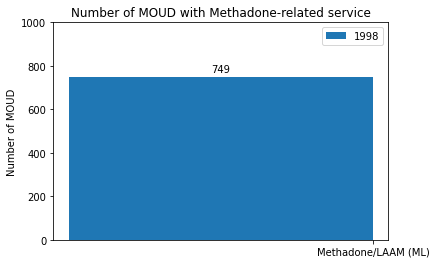

In [16]:
#barchart: https://matplotlib.org/3.3.0/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py

import matplotlib.pyplot as plt
import numpy as np


labels = ['Methadone/LAAM (ML)']
men_means = [749]
women_means = [749]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, men_means, width, label='1998')
#rects2 = ax.bar(x + width/2, women_means, width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of MOUD')
ax.set_title('Number of MOUD with Methadone-related service')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
#autolabel(rects2)

#fig.tight_layout()
#plt.ylim(0, 11324)
plt.savefig('1998_stats.png', bbox_inches = 'tight', dpi = 300)